# XGBoost
- is a state-of-art machine learning algorithm
- Description
  - Stands for extreme gradient boosting
  - Can be construcred with a tree based algorithm or linear (worse results)
  - It is an emsemble algorithm
  - Each new model is build upon the precednt one -> continuous improvement
  - Can be used for both Regression and Classification 
1. [Classification problems]XGBoost not look all observations at time, the omision someone at improve others. Only looks at a fraction of the observations at the time observations that are more dificult to predict are given a bigger weight;
2. [Regression problems]The logic is similar for regression-based tasks. It's similar the classification tasks, the diference is the mimimize errror outcome(how big error are?).
- XGBoost gives different weights depending on how difficult it is to predict;
- Is the model the calibrate weights throught iterations;
- Also gives differents weights to different predictors;
- Predictors also have different weights if they yield different model results.
- Quirks:
  - NA: Unlike other regression models, XGBoost treats NA's as information;
  - Non-Linearity: XGBoost is excellent dealing with non-linearity relationship between the dependent and the independent variables.


# MAE vs RMSE
- Are performance indicatros for Regression models with continuous dependent variables

    MAE = $\large \frac{\sum{y-\^y}}{n}$

    RMSE = $\large \sqrt[2]{\frac{\sum{y-\^y}^2}{n}}$

- RSME is quite useful for models with extrems/outliers;
- MAE is more interpretable.


# SHAP
- SHpley Additive exPlanations were introducted by Lundberg and Lee(2016)
- SHAP aims to explain each instance by computing the marginal contribution of each feature to the prediction
- SHAP computes each values using coalitional game theroy
- Gloabl interpratability: THE SHAP values can show how much each predictor contributes, either positively or negatively, to the target variable;
- Local interpretability: Each observation gets its own set of SHAP values. We can explain why a case receives its predictions and the contributions of the predictiors;
- Dependency Plots: Shows the relations between an independent variable and the ouput. Also shows how the predictor interactor with its closest independent variable.




# Case of study - Car prices
- Pricing a car
  - List of car, their price, and characteristics
   1. Build a XGBoost model to measure accuracy
   2. Use SHAP to get insights
- Step by Step
  1. Prepare dataset, isolate X and Y
  2. Split into training and Test set, and create Matrices
  3. Set Parameters
  4. Run XGBoost
  5. Assess Model
  6. Implement SHAP

# Imports

In [23]:
# !pip install shap
# !pip install xgboost

In [24]:
import shap

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load Data

In [25]:
data = pd.read_csv("./data/car_prices.csv")
data.head()

,Unnamed: 0,Price,Mileage,Cylinder,Doors,Cruise,Sound,Leather,Buick,Cadillac,Chevy,Pontiac,Saab,Saturn,convertible,coupe,hatchback,sedan,wagon
0,1,22661.05,20105,6,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,2,21725.01,13457,6,2,1,1,0,0,0,1,0,0,0,0,1,0,0,0
2,3,29142.71,31655,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0
3,4,30731.94,22479,4,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,5,33358.77,17590,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0


remove unwanted variable

In [26]:
data = data.iloc[:,1:]
data.head()

,Price,Mileage,Cylinder,Doors,Cruise,Sound,Leather,Buick,Cadillac,Chevy,Pontiac,Saab,Saturn,convertible,coupe,hatchback,sedan,wagon
0,22661.05,20105,6,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,21725.01,13457,6,2,1,1,0,0,0,1,0,0,0,0,1,0,0,0
2,29142.71,31655,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0
3,30731.94,22479,4,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,33358.77,17590,4,2,1,1,1,0,0,0,0,1,0,1,0,0,0,0


# Data Prep

isolate X and y

In [27]:
y = data.Price
X = data.iloc[:, 1:]

train test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 1502)
X_test.head()

,Mileage,Cylinder,Doors,Cruise,Sound,Leather,Buick,Cadillac,Chevy,Pontiac,Saab,Saturn,convertible,coupe,hatchback,sedan,wagon
524,22891,6,4,1,1,1,0,0,0,1,0,0,0,0,0,1,0
344,7278,4,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0
45,9795,4,4,1,1,1,0,0,0,0,1,0,0,0,0,1,0
144,14095,8,4,1,0,1,0,1,0,0,0,0,0,0,0,1,0
507,32458,4,4,0,0,0,0,0,0,0,0,1,0,0,0,1,0


Create XGBoost matrices

In [29]:
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

# XGBoost model

- **Minimum Child weight**:  relates to the sum of the weights of each observation. Low values can mean that maybe not a lot of observations are in the round
- **ETA: learning** rate. How fate do you wnat the model to learn?
- **Max depth:** how big should the tree be? bigger trees go into more detail.
- **Gamma: how** fast should the tree be split?-> it's related the amount of samples.
- **Subsample: share** of observations in each tree?
- **Colsample by tree**:  how much of the tree should be analysed per round?
- **Number of rounds**: How many times do we want the analysis to be run?

In [30]:
parameters = {'learning_rate': 0.3,
              'max_depth': 6, # Standard value
              'colsample_bytree': 1, 
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 0,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

XGBoost model initiate

In [42]:
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round  = 15,
                  evals = [(Test, "Price")],
                  verbose_eval = 2)

[0]	Price-rmse:15669.21678
[2]	Price-rmse:8322.17509
[4]	Price-rmse:4662.31745
[6]	Price-rmse:3132.78032
[8]	Price-rmse:2565.49040
[10]	Price-rmse:2437.89876
[12]	Price-rmse:2379.03239
[14]	Price-rmse:2363.40777


# Model Assessment

Predictions

In [32]:
predictions = model.predict(Test)
predictions[:5]

array([18486.89 , 12025.667, 32168.285, 41810.137, 11265.365],
      dtype=float32)

## MAE and RMSE

In [33]:
print(round(mean_absolute_error(y_test, predictions),0))
print(round(mean_squared_error(y_test, predictions),0))
print(round(np.sqrt(mean_squared_error(y_test, predictions)),0))

1664.0
5748097.0
2398.0


# SHAP

In [34]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

local interpretability

In [44]:
X_test.loc[144].to_frame().T

,Mileage,Cylinder,Doors,Cruise,Sound,Leather,Buick,Cadillac,Chevy,Pontiac,Saab,Saturn,convertible,coupe,hatchback,sedan,wagon
144,14095,8,4,1,0,1,0,1,0,0,0,0,0,0,0,1,0


In [35]:
# Start javascript
shap.initjs()

# Plot a local shape values 
shap.force_plot(explainer.expected_value, shap_values[3,:],X_test.loc[144])

In [36]:
X_test.head()

,Mileage,Cylinder,Doors,Cruise,Sound,Leather,Buick,Cadillac,Chevy,Pontiac,Saab,Saturn,convertible,coupe,hatchback,sedan,wagon
524,22891,6,4,1,1,1,0,0,0,1,0,0,0,0,0,1,0
344,7278,4,4,0,0,0,0,0,1,0,0,0,0,0,0,1,0
45,9795,4,4,1,1,1,0,0,0,0,1,0,0,0,0,1,0
144,14095,8,4,1,0,1,0,1,0,0,0,0,0,0,0,1,0
507,32458,4,4,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [37]:
shap_values

array([[ -829.44934 ,  1112.7115  ,  -276.12036 , ...,    46.51423 ,
          -85.170944,   -75.402695],
       [ 1968.7937  , -4955.132   ,  -168.05565 , ...,   -29.318064,
          -12.217857,   -53.560143],
       [ 3857.2075  , -2565.8816  ,  -374.22586 , ...,    55.52459 ,
         -336.87088 ,   -41.11927 ],
       ...,
       [   23.147125,   547.13745 ,   723.93195 , ...,   -21.74414 ,
          -26.119389,   -50.58614 ],
       [-1107.6981  , -3656.3489  ,   672.68823 , ...,    53.280037,
           91.86029 ,  -100.03581 ],
       [ -416.9356  ,  1305.1877  ,  -299.61746 , ...,    33.425972,
         -113.3908  ,   -66.40466 ]], dtype=float32)

## All local interpretation

all individuals predictions

In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

## Dependency plots

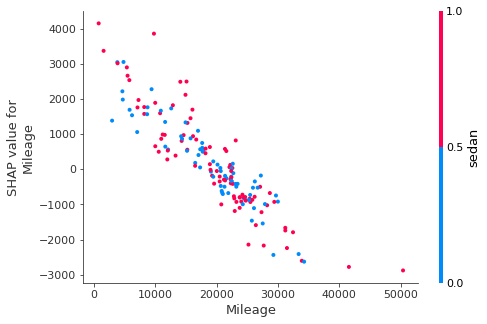

In [45]:
shap.dependence_plot("Mileage", shap_values, X_test)


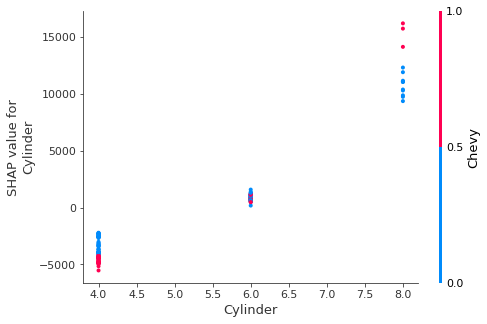

In [39]:
shap.dependence_plot("Cylinder", shap_values, X_test)

## Summary plot

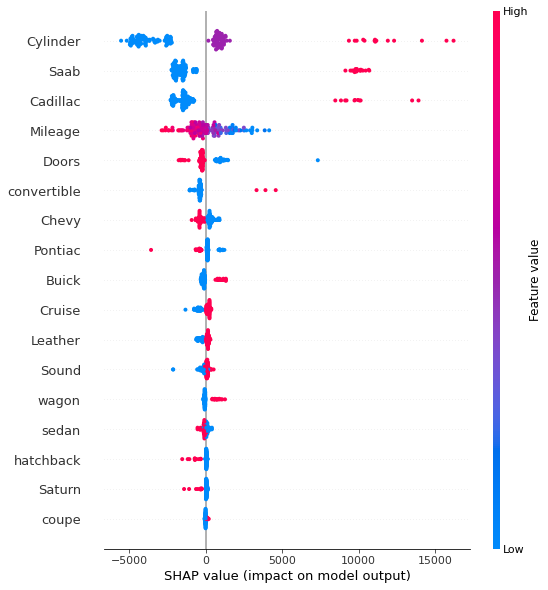

In [40]:
shap.summary_plot(shap_values, X_test)